In [1]:
!pip install tensorflow flwr -U "flwr[simulation]" numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: typer
    Found existing installation: typer 0.12.3
    Uninstalling typer-0.12.3:
      Successfully uninstalled typer-0.12.3
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires

In [ ]:
import os
import shutil
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import flwr as fl
from kaggle.api.kaggle_api_extended import KaggleApi

# Upload Kaggle API credentials
from google.colab import files
files.upload()

# Move credentials to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle API setup
!kaggle datasets list

# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content/data/raw --unzip

# Define the VGG16-based model
def build_model(num_classes):
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model) if num_classes == 2 else Dense(num_classes, activation='softmax')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    model.compile(loss='binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

# Function to split data into training and testing directories
def split_data(data_dir, train_dir, test_dir, test_size=0.2):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            if not os.path.exists(train_class_dir):
                os.makedirs(train_class_dir)
            if not os.path.exists(test_class_dir):
                os.makedirs(test_class_dir)

            images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))]
            if len(images) == 0:
                print(f"No images found in {class_dir}")
                continue

            train_images, test_images = train_test_split(images, test_size=test_size)
            if len(train_images) == 0 or len(test_images) == 0:
                print(f"Not enough images to split in {class_dir}")
                continue

            for img in train_images:
                shutil.copy(img, train_class_dir)
            for img in test_images:
                shutil.copy(img, test_class_dir)

# Function to load training, validation, and test data
def load_data():
    # Define directories
    data_dir = "/content/data/"
    raw_data_dir = os.path.join(data_dir, "raw", "brain_tumor_dataset")
    train_dir = os.path.join(data_dir, "Training")
    test_dir = os.path.join(data_dir, "Test")

    # Split the data into training and testing sets
    split_data(raw_data_dir, train_dir, test_dir, test_size=0.2)

    # Data augmentation and preprocessing
    data_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

    train_generator = data_gen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        subset='training',
        class_mode='binary'
    )

    validation_generator = data_gen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=False,
        subset='validation',
        class_mode='binary'
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_data_gen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=False,
        class_mode='binary'
    )

    return train_generator, validation_generator, test_generator

# Custom client class for federated learning
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, train_generator, validation_generator, test_generator):
        self.model = model
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.test_generator = test_generator

    def get_parameters(self, config):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(self.train_generator, epochs=1, steps_per_epoch=len(self.train_generator))
        return self.get_parameters(config), len(self.train_generator), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = self.model.evaluate(self.validation_generator)
        return loss, len(self.validation_generator), {"accuracy": accuracy}

    def evaluate_test(self):
        loss, accuracy = self.model.evaluate(self.test_generator)
        return loss, accuracy

# Function to create a FlowerClient instance
def client_fn(cid: str) -> FlowerClient:
    num_classes = 2
    model = build_model(num_classes)
    train_generator, validation_generator, test_generator = load_data()
    return FlowerClient(model, train_generator, validation_generator, test_generator)

# Define the federated learning strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Use all clients for training
    fraction_evaluate=0.5,  # Use half of the clients for evaluation
    min_fit_clients=2,  # Minimum number of clients to train
    min_evaluate_clients=1,  # Minimum number of clients to evaluate
    min_available_clients=2,  # Minimum number of available clients
)

# Start the federated learning simulation
fl.simulation.start_simulation(
    client_fn=client_fn,  # Specifies the client function
    num_clients=2,  # Number of clients
    config=fl.server.ServerConfig(num_rounds=5),  # Server configuration with 5 rounds
    strategy=strategy,  # Federated learning strategy
    client_resources={"num_cpus": 1, "num_gpus": 0.0}  # Resources allocated to each client
)

# Evaluate the test dataset after federated learning
clients = [client_fn(str(i)) for i in range(2)]  # Initialize clients
for client in clients:
    test_loss, test_accuracy = client.evaluate_test()
    print(f"Client {client} Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


ModuleNotFoundError: No module named 'flwr'

In [3]:
import os
import shutil
import pickle
# Upload Kaggle API credentials
from google.colab import files
files.upload()

# Move credentials to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import flwr as fl
from kaggle.api.kaggle_api_extended import KaggleApi

# Upload Kaggle API credentials
from google.colab import files
files.upload()

# Move credentials to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle API setup
!kaggle datasets list

# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection -p /content/data/raw --unzip

# Define the VGG16-based model
def build_model(num_classes):
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    top_model = base_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(1, activation='sigmoid')(top_model) if num_classes == 2 else Dense(num_classes, activation='softmax')(top_model)

    model = Model(inputs=base_model.input, outputs=top_model)
    model.compile(loss='binary_crossentropy' if num_classes == 2 else 'categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])
    return model

# Function to split data into training and testing directories
def split_data(data_dir, train_dir, test_dir, test_size=0.2):
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            if not os.path.exists(train_class_dir):
                os.makedirs(train_class_dir)
            if not os.path.exists(test_class_dir):
                os.makedirs(test_class_dir)

            images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, img))]
            if len(images) == 0:
                print(f"No images found in {class_dir}")
                continue

            train_images, test_images = train_test_split(images, test_size=test_size)
            if len(train_images) == 0 or len(test_images) == 0:
                print(f"Not enough images to split in {class_dir}")
                continue

            for img in train_images:
                shutil.copy(img, train_class_dir)
            for img in test_images:
                shutil.copy(img, test_class_dir)

# Function to load training, validation, and test data
def load_data():
    # Define directories
    data_dir = "/content/data/"
    raw_data_dir = os.path.join(data_dir, "raw", "brain_tumor_dataset")
    train_dir = os.path.join(data_dir, "Training")
    test_dir = os.path.join(data_dir, "Test")

    # Split the data into training and testing sets
    split_data(raw_data_dir, train_dir, test_dir, test_size=0.2)

    # Data augmentation and preprocessing
    data_gen = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_input)

    train_generator = data_gen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=True,
        subset='training',
        class_mode='binary'
    )

    validation_generator = data_gen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=False,
        subset='validation',
        class_mode='binary'
    )

    test_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
    test_generator = test_data_gen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        shuffle=False,
        class_mode='binary'
    )

    return train_generator, validation_generator, test_generator

# Custom client class for federated learning
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, train_generator, validation_generator, test_generator):
        self.model = model
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.test_generator = test_generator

    def get_parameters(self, config):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        self.model.fit(self.train_generator, epochs=1, steps_per_epoch=len(self.train_generator))
        return self.get_parameters(config), len(self.train_generator), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = self.model.evaluate(self.validation_generator)
        return loss, len(self.validation_generator), {"accuracy": accuracy}

    def evaluate_test(self):
        loss, accuracy = self.model.evaluate(self.test_generator)
        return loss, accuracy

# Function to create a FlowerClient instance
def client_fn(cid: str) -> FlowerClient:
    num_classes = 2
    model = build_model(num_classes)
    train_generator, validation_generator, test_generator = load_data()
    return FlowerClient(model, train_generator, validation_generator, test_generator)

# Define the federated learning strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Use all clients for training
    fraction_evaluate=0.5,  # Use half of the clients for evaluation
    min_fit_clients=2,  # Minimum number of clients to train
    min_evaluate_clients=1,  # Minimum number of clients to evaluate
    min_available_clients=2,  # Minimum number of available clients
)

# Start the federated learning simulation
fl.simulation.start_simulation(
    client_fn=client_fn,  # Specifies the client function
    num_clients=2,  # Number of clients
    config=fl.server.ServerConfig(num_rounds=5),  # Server configuration with 5 rounds
    strategy=strategy,  # Federated learning strategy
    client_resources={"num_cpus": 1, "num_gpus": 0.0}  # Resources allocated to each client
)

# Save each client's model
def save_client_model(client, client_id):
    # Save model weights to a pickle file
    with open(f"client_{client_id}_model.pkl", "wb") as file:
        pickle.dump(client.model.get_weights(), file)
    print(f"Model for client {client_id} saved to client_{client_id}_model.pkl")

clients = [client_fn(str(i)) for i in range(2)]
for i, client in enumerate(clients):
    save_client_model(client, i)

# Load a client model from pickle
def load_client_model(client_id):
    # Build a new model
    num_classes = 2
    model = build_model(num_classes)

    # Load model weights from a pickle file
    with open(f"client_{client_id}_model.pkl", "rb") as file:
        model.set_weights(pickle.load(file))
    print(f"Model for client {client_id} loaded from client_{client_id}_model.pkl")

    return model

# Function to predict a single image
def predict_image(model, img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make a prediction
    prediction = model.predict(img_array)

    # Interpret the prediction
    return "yes" if prediction[0][0] > 0.5 else "no"




Saving kaggle.json to kaggle.json


Saving kaggle.json to kaggle.json
ref                                                           title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                   📚 Students Performance Dataset 📚                  66KB  2024-06-12 23:09:20          25529        515  1.0              
marius2303/nissan-all-models-price-prediction-dataset         Nissan All Models Price Prediction Dataset       811KB  2024-07-27 11:50:10            838         24  1.0              
harinkl/import-and-export-of-india-2009-2025                  import and export of india 2009-2025             364KB  2024-07-20 04:37:38           1582         26  1.0              
ihelon/coffee-sales                                

INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-02 04:24:15,869	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 7995688551.0, 'object_store_memory': 3997844275.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1307) 2024-08-02 04:24:19.826551: E external/local

(ClientAppActor pid=1308) Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
       0/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
 4202496/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
21495808/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
41172992/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(ClientAppActor pid=1308) Found 163 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 39 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 51 images belonging to 2 classes.


(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
(ClientAppActor pid=1308) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1308) 
(ClientAppActor pid=1308)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1308)             entirely in future versions of Flower.
(ClientAppActor pid=1308)         
(pid=1308) 2024-08-02 04:24:22.486161: W tensorf

(ClientAppActor pid=1308) Found 197 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 48 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 94 images belonging to 2 classes.


(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1307)          [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1307)             entirely in future versions of Flower.
(ClientAppActor pid=1308) /usr/local/lib/python3.10/dist-packag

1/7 ━━━━━━━━━━━━━━━━━━━━ 4:58 50s/step - accuracy: 0.3750 - loss: 1.0374
(ClientAppActor pid=1307) Found 124 images belonging to 2 classes. [repeated 3x across cluster]
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:23 41s/step - accuracy: 0.4453 - loss: 0.9975
1/7 ━━━━━━━━━━━━━━━━━━━━ 5:06 51s/step - accuracy: 0.5000 - loss: 0.8629
3/7 ━━━━━━━━━━━━━━━━━━━━ 1:46 27s/step - accuracy: 0.5694 - loss: 0.7795 [repeated 2x across cluster]
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:48 42s/step - accuracy: 0.4774 - loss: 0.9879
4/7 ━━━━━━━━━━━━━━━━━━━━ 1:36 32s/step - accuracy: 0.5914 - loss: 0.7585
4/7 ━━━━━━━━━━━━━━━━━━━━ 2:06 42s/step - accuracy: 0.4987 - loss: 0.9751
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:08 34s/step - accuracy: 0.6059 - loss: 0.7412
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:24 42s/step - accuracy: 0.5227 - loss: 0.9503
6/7 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step - accuracy: 0.6193 - loss: 0.7248 
6/7 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step - accuracy: 0.5406 - loss: 0.9271 
7/7 ━━━━━━━━━━━━━━━━━━━━ 269s 37s/step - accuracy: 0.5641 - loss: 0.8974

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=1307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1307)             entirely in future versions of Flower.
(ClientAppActor pid=1307)          [repeated 2x across cluster]
(ClientAppActor pid=1307) /usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
(Cl

(ClientAppActor pid=1307) Found 202 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 148 images belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 21s 22s/step - accuracy: 0.8125 - loss: 0.3540
7/7 ━━━━━━━━━━━━━━━━━━━━ 271s 37s/step - accuracy: 0.6361 - loss: 0.6982


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 12s/step - accuracy: 0.7642 - loss: 0.4470


(ClientAppActor pid=1307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1307)             entirely in future versions of Flower.
(ClientAppActor pid=1307)          [repeated 2x across cluster]
(ClientAppActor pid=1308) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1308)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1308)             entirely in future versions of Flower.
(ClientAppActor pid=1307) WARNING :   Deprecation Warning:

(ClientAppActor pid=1307) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 177 images belonging to 2 classes.
1/7 ━━━━━━━━━━━━━━━━━━━━ 5:11 52s/step - accuracy: 0.7500 - loss: 0.3800
(ClientAppActor pid=1308) Found 190 images belonging to 2 classes. [repeated 3x across cluster]
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:45 45s/step - accuracy: 0.7344 - loss: 0.4535
1/7 ━━━━━━━━━━━━━━━━━━━━ 5:24 54s/step - accuracy: 0.6875 - loss: 0.4886
3/7 ━━━━━━━━━━━━━━━━━━━━ 1:59 30s/step - accuracy: 0.6694 - loss: 0.5148 [repeated 2x across cluster]
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:51 43s/step - accuracy: 0.7396 - loss: 0.4669
4/7 ━━━━━━━━━━━━━━━━━━━━ 1:44 35s/step - accuracy: 0.6843 - loss: 0.5099
4/7 ━━━━━━━━━━━━━━━━━━━━ 2:08 43s/step - accuracy: 0.7500 - loss: 0.4640
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:11 36s/step - accuracy: 0.7554 - loss: 0.4639
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:13 37s/step - accuracy: 0.7014 - loss: 0.4961
6/7 ━━━━━━━━━━━━━━

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=1308) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1308)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1308)             entirely in future versions of Flower.
(ClientAppActor pid=1308)          [repeated 4x across cluster]
(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1308) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 201 images belonging to 2 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 284s 38s/step - accuracy: 0.7366 - loss: 0.4688


(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


1/2 ━━━━━━━━━━━━━━━━━━━━ 22s 23s/step - accuracy: 0.8750 - loss: 0.2712


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 11s/step - accuracy: 0.8650 - loss: 0.2787


(ClientAppActor pid=1308) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1308)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1308)             entirely in future versions of Flower.
(ClientAppActor pid=1308)          [repeated 2x across cluster]
(ClientAppActor pid=1307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1307) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 222 images belonging to 2 classes.
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:45 48s/step - accuracy: 0.9375 - loss: 0.2219
(ClientAppActor pid=1308) Found 222 images belonging to 2 classes. [repeated 3x across cluster]
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:39 44s/step - accuracy: 0.8750 - loss: 0.3314
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:54 49s/step - accuracy: 0.9375 - loss: 0.2872
3/7 ━━━━━━━━━━━━━━━━━━━━ 1:58 30s/step - accuracy: 0.8544 - loss: 0.3649 [repeated 2x across cluster]
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:47 42s/step - accuracy: 0.8889 - loss: 0.2861
4/7 ━━━━━━━━━━━━━━━━━━━━ 1:38 33s/step - accuracy: 0.8793 - loss: 0.2891
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:11 36s/step - accuracy: 0.8689 - loss: 0.2975 [repeated 2x across cluster]
6/7 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.8413 - loss: 0.3770  [repeated 2x across cluster]
7/7 ━━━━━━━━━━━━━━━━━━━━ 278s 38s

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=1307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1307)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1307)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1307)          [repeated 4x across cluster]
(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=1307) WARNING :   De

(ClientAppActor pid=1307) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 231 images belonging to 2 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.8125 - loss: 0.3903
7/7 ━━━━━━━━━━━━━━━━━━━━ 278s 38s/step - accuracy: 0.8614 - loss: 0.2977


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 39s 17s/step - accuracy: 0.8308 - loss: 0.3273


(ClientAppActor pid=1307) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1307)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1307)             entirely in future versions of Flower.
(ClientAppActor pid=1307)          [repeated 2x across cluster]
(ClientAppActor pid=1308) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1308)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1308)             entirely in future versions of Flower.
(ClientAppActor pid=1307) WARNING :   Deprecation Warning:

(ClientAppActor pid=1307) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1307) Found 239 images belonging to 2 classes.
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:55 49s/step - accuracy: 0.9062 - loss: 0.2197
(ClientAppActor pid=1308) Found 241 images belonging to 2 classes. [repeated 3x across cluster]
2/7 ━━━━━━━━━━━━━━━━━━━━ 3:36 43s/step - accuracy: 0.8750 - loss: 0.2820
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:59 50s/step - accuracy: 0.9062 - loss: 0.2641
3/7 ━━━━━━━━━━━━━━━━━━━━ 2:51 43s/step - accuracy: 0.8698 - loss: 0.3198 [repeated 2x across cluster]
4/7 ━━━━━━━━━━━━━━━━━━━━ 1:38 33s/step - accuracy: 0.8696 - loss: 0.3168 [repeated 2x across cluster]
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:11 36s/step - accuracy: 0.8712 - loss: 0.3114 [repeated 2x across cluster]
6/7 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.8732 - loss: 0.3074  [repeated 2x across cluster]
7/7 ━━━━━━━━━━━━━━━━━━━━ 277s 38s/step - accuracy: 0.8778 - loss: 0.2979
6/7 

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=1308) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1308)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1308)             entirely in future versions of Flower.
(ClientAppActor pid=1308)          [repeated 4x across cluster]
(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1308) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 244 images belonging to 2 classes.


(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


1/2 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.8750 - loss: 0.3530
7/7 ━━━━━━━━━━━━━━━━━━━━ 278s 38s/step - accuracy: 0.8556 - loss: 0.3120


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)


2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 10s/step - accuracy: 0.8917 - loss: 0.3062


(ClientAppActor pid=1308) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=1308)             This is a deprecated feature. It will be removed
(ClientAppActor pid=1308)             entirely in future versions of Flower.
(ClientAppActor pid=1308)          [repeated 2x across cluster]


(ClientAppActor pid=1308) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 247 images belonging to 2 classes.


(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


1/7 ━━━━━━━━━━━━━━━━━━━━ 2:07 21s/step - accuracy: 1.0000 - loss: 0.0967
(ClientAppActor pid=1307) Found 248 images belonging to 2 classes. [repeated 3x across cluster]
1/7 ━━━━━━━━━━━━━━━━━━━━ 4:42 47s/step - accuracy: 0.9688 - loss: 0.1586
2/7 ━━━━━━━━━━━━━━━━━━━━ 1:16 15s/step - accuracy: 0.9495 - loss: 0.2008
3/7 ━━━━━━━━━━━━━━━━━━━━ 1:57 29s/step - accuracy: 0.9352 - loss: 0.2068 [repeated 2x across cluster]
4/7 ━━━━━━━━━━━━━━━━━━━━ 1:41 34s/step - accuracy: 0.9351 - loss: 0.2002 [repeated 2x across cluster]
5/7 ━━━━━━━━━━━━━━━━━━━━ 1:24 42s/step - accuracy: 0.9740 - loss: 0.1255 [repeated 2x across cluster]
6/7 ━━━━━━━━━━━━━━━━━━━━ 42s 43s/step - accuracy: 0.9725 - loss: 0.1268  [repeated 2x across cluster]
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43s/step - accuracy: 0.9701 - loss: 0.1291 
6/7 ━━━━━━━━━━━━━━━━━━━━ 37s 38s/step - accuracy: 0.9267 - loss: 0.2021 
7/7 ━━━━━━━━━━━━━━━━━━━━ 278s 43s/step - accuracy: 0.9683 - loss: 0.1308
7/7 ━━━━━━━━━━━━━━━━━━━━ 280s 39s/step - accuracy: 0.9192 -

INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 1 clients (out of 2)
(ClientAppActor pid=1308) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 2x across cluster]
(ClientAppActor pid=1308)             This is a deprecated feature. It will be removed [repeated 2x across cluster]
(ClientAppActor pid=1308)             entirely in future versions of Flower. [repeated 2x across cluster]
(ClientAppActor pid=1308)          [repeated 4x across cluster]
(ClientAppActor pid=1307) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=1308) Found 203 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 50 images belonging to 2 classes.
(ClientAppActor pid=1308) Found 248 images belonging to 2 classes.


(ClientAppActor pid=1308) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


1/2 ━━━━━━━━━━━━━━━━━━━━ 23s 24s/step - accuracy: 0.8750 - loss: 0.2697


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 1590.47s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.49343445897102356
INFO :      		round 2: 0.2825148105621338
INFO :      		round 3: 0.29579514265060425
INFO :      		round 4: 0.2828432619571686
INFO :      		round 5: 0.23772044479846954
INFO :      


2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 13s/step - accuracy: 0.8783 - loss: 0.2484
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 249 images belonging to 2 classes.
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 251 images belonging to 2 classes.
Model for client 0 saved to client_0_model.pkl
Model for client 1 saved to client_1_model.pkl


Model for client 0 loaded from client_0_model.pkl
Model for client 1 loaded from client_1_model.pkl


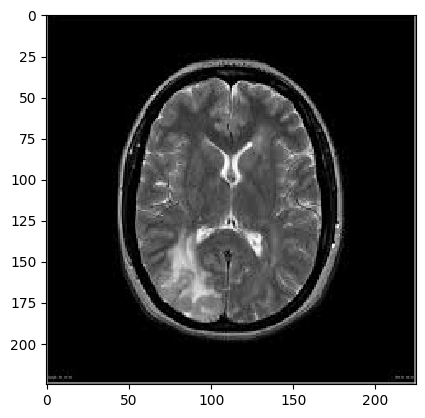

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
Prediction for the image from client 1: no
Prediction for the image from client 2: no


In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Example usage
client_id_1 = 0  # Specify the client ID to use for prediction
client_id_2= 1
model1 = load_client_model(client_id_1)
model2 = load_client_model(client_id_2)
# img_path = "/content/data/raw/brain_tumor_dataset/no/11 no.jpg"  # Replace with your image path

img_path = "/content/data/raw/brain_tumor_dataset/no/32 no.jpg"

# img_path = "/content/data/raw/brain_tumor_dataset/no/14 no.jpg"


# Load the image data using mpimg.imread
img = mpimg.imread(img_path)

plt.imshow(img, interpolation='nearest') # Pass the image data to imshow
plt.show()


prediction1 = predict_image(model1, img_path)
prediction2= predict_image(model2, img_path)
print(f"Prediction for the image from client 1: {prediction1}")
print(f"Prediction for the image from client 2: {prediction2}")